<a href="https://colab.research.google.com/github/Nikitha1418/INFO5731/blob/master/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Write your code here
import re
import os
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
df = pd.read_csv('/content/machine_learning.csv')
print(df)

                                               Topics
0                                    Machine Learning
1                    Introduction to machine learning
2            Scikit-learn: Machine learning in Python
3            Pattern recognition and machine learning
4                            Quantum machine learning
..                                                ...
95  Convolutional LSTM network: A machine learning...
96  Machine learning classifiers and fMRI: a tutor...
97  Flow clustering using machine learning techniques
98  Practical black-box attacks against machine le...
99  Federated machine learning: Concept and applic...

[100 rows x 1 columns]


In [ ]:
# Convert to list
data = df['Topics'].tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Machine Learning']


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['machine', 'learning']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['machine', 'learning']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['machine']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [ ]:
id2word[0]

'machine'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('machine', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.75816310738616

Coherence Score:  0.5919681274685648


In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

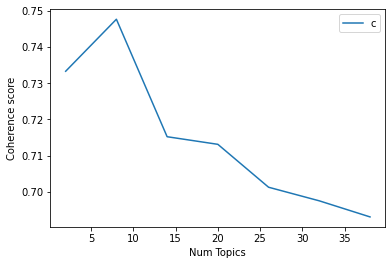

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7333
Num Topics = 8  has Coherence Value of 0.7477
Num Topics = 14  has Coherence Value of 0.7152
Num Topics = 20  has Coherence Value of 0.7131
Num Topics = 26  has Coherence Value of 0.7012
Num Topics = 32  has Coherence Value of 0.6975
Num Topics = 38  has Coherence Value of 0.693


In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.048*"nowcasting" + 0.048*"precipitation" + 0.048*"torch" + '
  '0.048*"environment" + 0.047*"approach" + 0.006*"learning" + 0.006*"machine" '
  '+ 0.005*"learn" + 0.005*"mining" + 0.005*"method"'),
 (1,
  '0.152*"machine" + 0.092*"learn" + 0.040*"learning" + 0.035*"practical" + '
  '0.024*"next" + 0.024*"network" + 0.024*"generation" + 0.024*"perspective" + '
  '0.023*"technique" + 0.014*"use"'),
 (2,
  '0.274*"machine" + 0.215*"learning" + 0.021*"method" + 0.017*"approach" + '
  '0.013*"algorithm" + 0.013*"application" + 0.013*"process" + '
  '0.013*"optimization" + 0.009*"system" + 0.009*"technique"'),
 (3,
  '0.156*"machine" + 0.126*"learn" + 0.052*"survey" + 0.052*"system" + '
  '0.028*"descent" + 0.028*"stochastic" + 0.028*"gradient" + '
  '0.028*"bioinformatic" + 0.028*"imaging" + 0.028*"scale"'),
 (4,
  '0.034*"address" + 0.034*"ethical" + 0.034*"implement" + 0.034*"care" + '
  '0.034*"health" + 0.034*"artificial" + 0.034*"intelligence" + '
  '0.034*"probabilistic" + 0

LDA Topics


*   Casting precipition torch environment using Machine Learning

*  New practical learning network used for the perspective of next generation

* Machine Leanring for optimization of the application systems

* Descent survey scale system using gradient bioinformatic stochastic imaging

* probabilistic implmented address in health care, ethical mining and artificial intelligence

* Feature selection of high speed scikit base correlation corner using Machine Learning

* Predicting clinical medicine and big inference membership model

* Adversarial optimization using heterogenous tensorflow system



## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values_lsa(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values_lsa = compute_coherence_values_lsa(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

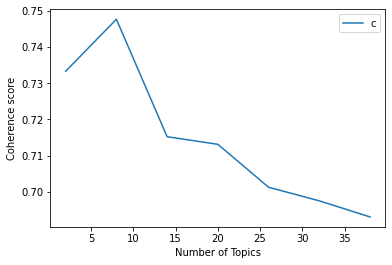

In [ ]:
start,stop,step=2,40,6
plot_graph(data_lemmatized,start,stop,step)

In [ ]:
# LSA Model
number_of_topics = 2
words = 10
model = create_gensim_lsa_model(data_lemmatized,number_of_topics,words)

[(0, '0.798*"machine" + 0.556*"learning" + 0.136*"learn" + 0.053*"method" + 0.052*"system" + 0.045*"algorithm" + 0.043*"scale" + 0.042*"practical" + 0.038*"technique" + 0.037*"large"'), (1, '-0.708*"learn" + 0.562*"learning" + -0.262*"machine" + -0.081*"scale" + -0.079*"generation" + -0.079*"next" + -0.079*"network" + -0.075*"big" + -0.070*"large" + -0.070*"probabilistic"')]


In [ ]:
dictionary,doc_term_matrix= prepare_corpus(data_lemmatized)
model_list_lsa,coherence_values_lsa = compute_coherence_values_lsa(dictionary,doc_term_matrix,data_lemmatized,40,2,6)

In [ ]:
for m, cv in zip(x, coherence_values_lsa):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5747
Num Topics = 8  has Coherence Value of 0.5747
Num Topics = 14  has Coherence Value of 0.4848
Num Topics = 20  has Coherence Value of 0.5809
Num Topics = 26  has Coherence Value of 0.5747
Num Topics = 32  has Coherence Value of 0.5809
Num Topics = 38  has Coherence Value of 0.5747


LSA Topics

* Machine Learning for pratical system.

* Large probabilistic big scale network of future learning generation

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
#For LDA: Latent Dirichlet Allocation

Coherence Value = 0.7522

Num Topics = 8  

#For LSA :Latent Semantic Analysis

Coherence Value = 0.5284

Num Topics = 2  

#LSA is a linear algebra method whereas LDA is probabilistic.LDA is easily the most effective topic modeling technique. Initially the coherence value is of 0.6995, later after increasing up the steps we have got the number of topics also increased. 
#Overall i can say that LDA has the highest Coherence value that means LDA has more accuracy compared to that of LSA.